In [1]:
import re, os, sys, platform, json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.colors

In [44]:
import pandas as pd
import re


def clean(text, removeitems):
    if not isinstance(text, str):
        return ""
    for item in removeitems:
        text = text.replace(item, "")
    text = re.sub(r"\s+", " ", text)
    return text

def extract_number(s, default=-1):
    digits = "".join(filter(str.isdigit, str(s)))
    return int(digits) if digits else default


removeItems = ["!", "?", ".", ",", "--", '"', "'", "”", "“", "’", "‘", "…", "*", "[", "]", "(", ")"]
# removeItems =[]
# with open("removeitems.txt", "r") as f:
#     removeItems += [line.strip() for line in f.readlines()]

df = pd.read_excel("/Users/oliviafeng/Desktop/uchi/digital_text2/RM/RnM_Transcripts-2024-11-28_11-20-1.xlsx")


df_valid = df[df["Season"].notna() & df["Episode"].notna() & df["Transcript"].notna()]

texts = [clean(t, removeItems) for t in df_valid["Transcript"]]


labels = [[
    f"S{extract_number(s):02d}E{extract_number(e):02d}",  # episode_id
    str(extract_number(s)),                               # season
    str(extract_number(e))                                # episode number
] for s, e in zip(df_valid["Season"], df_valid["ep_number"])]


labelTypes = ("episode_id", "season", "episode_number")


labelValue = 0  # 图中每个点旁边的标签，显示 episode_id
colorValue = 1  # 用 season 上色

pointSize = 5
pointLabels = True
plotLoadings = False
hidePoints = False
outputDimensions = (10, 7.5)
outputFile = "WS_PCA.pdf"

In [45]:
# Size of n-grams:
ngrams = 1

# Limit the number of words to look at
commonWords = 200 

# Set the vocabulary you are interested in
limitVocab = False

# Vocabulary file
limitVocabularyFile = "vocab.txt"

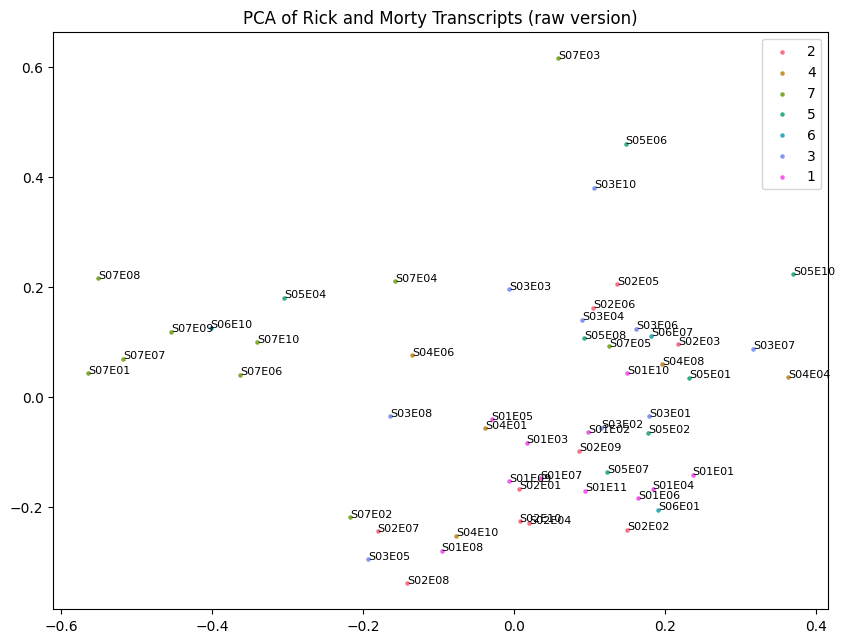

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import os

# 向量化
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
countMatrix = vectorizer.fit_transform(texts)
countMatrix = normalize(countMatrix).toarray()

# PCA
pca = PCA(n_components=2)
myPCA = pca.fit_transform(countMatrix)

# 生成分类映射
uniqueLabelValues = [set() for _ in range(len(labelTypes))]
for labelList in labels:
    for i, label in enumerate(labelList):
        uniqueLabelValues[i].add(label)

colorDictionaries = []
for uniqueLabels in uniqueLabelValues:
    palette = sns.color_palette("husl", len(uniqueLabels)).as_hex()
    colorDictionaries.append(dict(zip(uniqueLabels, palette)))

uniqueColorLabels = list(uniqueLabelValues[colorValue])
labelForClassNumber = dict(zip(uniqueColorLabels, range(len(uniqueColorLabels))))
textClass = np.array([labelForClassNumber[lab[colorValue]] for lab in labels])
colors = [colorDictionaries[colorValue][lab] for lab in uniqueColorLabels]

# 绘图
plt.figure(figsize=outputDimensions)
for col, classNumber, lab in zip(colors, range(len(uniqueColorLabels)), uniqueColorLabels):
    plt.scatter(myPCA[textClass == classNumber, 0], myPCA[textClass == classNumber, 1], label=lab, c=col, s=pointSize)

if pointLabels:
    for lab, datapoint in zip(labels, myPCA):
        plt.annotate(str(lab[labelValue]), xy=datapoint, fontsize=8)

plt.legend()
plt.title("PCA of Rick and Morty Transcripts (raw version)")
plt.savefig(outputFile)
plt.show()
